# Minerva: AI Guardian for Scam Protection

This notebook implements a multi-agent system for analyzing images (screenshots) to identify scam attempts, and provide personalized scam prevention. It uses [AutoGen](https://github.com/microsoft/autogen/) to orchestrate various specialized agents that work together.

Benefits:
- Automates the process of identifying suspicious scam patterns.
- Prevent Financial Loss
- Save Time: Early scam detection reduces the number of claims filed by end-users.

## Install Dependencies

In [3]:
%pip install -q pyautogen pillow pytesseract

Note: you may need to restart the kernel to use updated packages.


In [44]:
import autogen
from IPython.display import Image as IPImage
from IPython.display import display

In [45]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

llm_config = [
    {
        "model": "gpt-4o-mini",
        "api_key": os.getenv("OPENAI_API_KEY")
    }
]

## Tools Definition

In [46]:
def ocr(image_path: str) -> str:
    from PIL import Image
    import pytesseract

    try:
        image = Image.open(image_path)
        text = pytesseract.image_to_string(image)
        return text
    except Exception as e:
        return f"Error in text extraction: {str(e)}"

## Agents Creation

In [47]:
def create_agents():
    """Create and initialize the specialized agents."""
    
    # OCR Agent - Extracts and processes text from images
    ocr_agent = autogen.AssistantAgent(
        name="OCR_Specialist",
        system_message="""You are an OCR specialist. Your role is to:
        1. Extract text from an image path using pytesseract
        2. Clean and format the extracted text for further analysis""",
        llm_config={"config_list": llm_config}
    )

    # Content Analysis Agent - Evaluates text content for scam signals
    content_agent = autogen.AssistantAgent(
        name="Content_Analyst",
        system_message="""You are a content analysis specialist. Your role is to:
        1. Analyze text for common scam patterns
        2. Identify and analyze URLs, phone numbers, or other contact information
        3. Identify urgency indicators, threats, or pressure tactics
        5. Check for inconsistencies in messaging
        6. Evaluate legitimacy of any claims or offers""",
        llm_config={"config_list": llm_config}
    )

    # Decision Making Agent - Makes final determination based on all analyses
    decision_agent = autogen.AssistantAgent(
        name="Decision_Maker",
        system_message="""You are the final decision maker. Your role is to:
        1. Coordinate with other agents to gather all necessary information
        2. Make a final determination on scam probability
        3. Provide detailed explanation of the decision
        4. End your explanation with the label as 'TASK_COMPLETE' when done""",
        llm_config={"config_list": llm_config}
    )

    summary_agent = autogen.AssistantAgent(
        name="Summary_Agent",
        system_message="""You are a communication specialist who creates clear, concise summaries of technical analyses. Your role is to:
        1. Synthesize the findings of a scam assessment into user-friendly language
        2. Highlight the most important points that users need to know
        3. Provide actionable recommendations
        4. Use clear, non-technical language while maintaining accuracy
        5. Format information in a way that's easy to read and understand""",
        llm_config={"config_list": llm_config}
    )

    # User proxy for automated interaction and code execution
    user_proxy = autogen.UserProxyAgent(
        name="User_Proxy",
        human_input_mode="NEVER",
        max_consecutive_auto_reply=5,
        is_termination_msg=lambda x: "TASK_COMPLETE" in x.get("content", ""),
    )

    ocr_agent.register_for_llm(name="ocr", description="Extracts text from an image path")(ocr)
    user_proxy.register_for_execution(name="ocr")(ocr)
    
    return ocr_agent, content_agent, decision_agent, user_proxy 

## Workflow

In [48]:
class ScamDetectionWorkflow:
    def __init__(self):
        self.ocr_agent, self.content_agent, self.decision_agent, self.user_proxy = create_agents()
        
    def analyze(self, image_path):
        """Coordinate the multi-agent analysis.
        """
        image_path = "./samples/02.giftcard.message.scam.png"
        
        groupchat = autogen.GroupChat(
            agents=[self.ocr_agent, self.content_agent, self.decision_agent, self.user_proxy],
            messages=[],
            max_round=10
        )
        manager = autogen.GroupChatManager(groupchat=groupchat)

        # Start the collaborative analysis
        messages = self.user_proxy.initiate_chat(
            manager,
            message=f"""Please analyze the content of an image for scam indicators:
            1. OCR Agent: Extract text from this image: {image_path}
            2. Content Agent: Evaluate the messaging and claims
            3. Decision Maker: Synthesize all analyses and make final determination""",
        )

        return messages

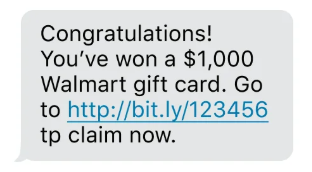

User_Proxy (to chat_manager):

Please analyze the content of an image for scam indicators:
            1. OCR Agent: Extract text from this image: ./samples/02.giftcard.message.scam.png
            2. Content Agent: Evaluate the messaging and claims
            3. Decision Maker: Synthesize all analyses and make final determination

--------------------------------------------------------------------------------

Next speaker: OCR_Specialist

OCR_Specialist (to chat_manager):

***** Suggested tool call (call_2CqBTFMP05FHbF5nQg93Kn5U): ocr *****
Arguments: 
{"image_path":"./samples/02.giftcard.message.scam.png"}
********************************************************************

--------------------------------------------------------------------------------

Next speaker: User_Proxy


>>>>>>>> EXECUTING FUNCTION ocr...
User_Proxy (to chat_manager):

***** Response from calling tool (call_2CqBTFMP05FHbF5nQg93Kn5U) *****
Congratulations!
You've won a $1,000
Walmart gift card. Go

http:

In [49]:
image_path = "./samples/02.giftcard.message.scam.png"
display(IPImage(filename=image_path))

workflow = ScamDetectionWorkflow()
results = workflow.analyze(image_path)

In [50]:
import pprint

pprint.pprint(results.chat_history[-1])

{'content': '### Final Determination on Scam Probability\n'
            '\n'
            '**Synthesis of Analyses**\n'
            '\n'
            "Both the OCR Agent's extraction and Content Analyst's evaluations "
            'reveal consistent and concerning indicators characteristic of '
            'fraud:\n'
            '\n'
            '1. **Claims of Winning**: Both analyses highlight the prominent '
            'claim of winning a $1,000 Walmart gift card without any prior '
            'engagement or contest participation. This is a common tactic in '
            'scams aiming to entice individuals with offers that sound too '
            'good to be true.\n'
            '\n'
            '2. **Urgency and Action Directive**: The urging phrase "Go tp '
            'claim now" was noted in both evaluations, showcasing an attempt '
            'to create urgency. This pressure is a typical strategy employed '
            'by scammers to rush potential victims into making impuls

In [51]:
import json


with open('results.json', 'w') as json_file:
    json.dump(results.__dict__, json_file, indent=4)